In [24]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
TEST_SIZE = 100
SELECTION_RATES = [0.1, 0.25, 0.5]

In [3]:
full_df = pd.read_csv("predictions/heloc/model_predictions.csv")
NUM_MODELS = len(full_df.columns)-1
full_df.head()

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,...,p_992,p_993,p_994,p_995,p_996,p_997,p_998,p_999,p_1000,y
0,0.60,0.40,0.72,0.36,0.60,0.20,0.60,0.32,0.36,0.36,...,0.56,0.40,0.48,0.36,0.44,0.44,0.20,0.36,0.32,0
1,0.28,0.28,0.16,0.28,0.48,0.20,0.28,0.48,0.44,0.20,...,0.24,0.28,0.20,0.40,0.28,0.32,0.24,0.24,0.28,0
2,0.76,0.72,0.56,0.68,0.68,0.84,0.64,0.72,0.60,0.80,...,0.84,0.64,0.76,0.76,0.76,0.76,0.52,0.76,0.80,1
3,0.64,0.68,0.64,0.72,0.84,0.60,0.68,0.76,0.76,0.52,...,0.76,0.60,0.52,0.64,0.64,0.80,0.60,0.56,0.64,1
4,0.20,0.08,0.12,0.00,0.12,0.16,0.20,0.20,0.36,0.16,...,0.20,0.20,0.04,0.48,0.20,0.12,0.00,0.20,0.20,0


In [29]:
def calculate_unique_allocations(k):
    # 1 -- What is the best precision?
    precision = {}
    for model in range(1, NUM_MODELS+1):
        allocation = df["p_"+str(model)].nlargest(k).index.to_list()
        precision[model] = int(df.loc[allocation, "y"].sum())
    best_precision = max(precision.values())

    # 2 -- Among models with best precision, calculate allocations    
    allocations = set()
    allocations_growth = []
    qualified_selections = []
    unqualified_selections = []
    for model in range(1, NUM_MODELS+1):
        if precision[model] != best_precision:
            if len(allocations_growth) == 0:
                allocations_growth.append(0)
            else:
                allocations_growth.append(allocations_growth[-1])
            continue
        
        allocation = df["p_"+str(model)].nlargest(k).index.to_list()

        selected = df.loc[allocation] 
        qualified_selections.append(selected[selected["y"]==1].index.to_list())
        unqualified_selections.append(selected[selected["y"]==0].index.to_list())
        
        allocation.sort()
        allocation = tuple(allocation)
        allocations.add(allocation)
        allocations_growth.append(len(allocations))

    qualified_selections = [item for sublist in qualified_selections for item in sublist]
    unqualified_selections = [item for sublist in unqualified_selections for item in sublist]
    qualified_count = dict(Counter(qualified_selections))
    unqualified_count = dict(Counter(unqualified_selections))
    
    return allocations_growth, best_precision, qualified_count.values(), unqualified_count.values()

## Homogenization: Unique Allocations with Equally-High Utility

In [34]:
results = []
allocations_growth = {}
qualified_count = {}
unqualified_count = {}
for rate in SELECTION_RATES:
    allocations_growth[rate] = []
    qualified_count[rate] = []
    unqualified_count[rate] = []
    
for i in tqdm(range(100)):
    df = full_df.sample(n=TEST_SIZE)

    for rate in SELECTION_RATES:
        k = int(rate * len(df))
        allocations, precision, qc, uqc = calculate_unique_allocations(k)
        allocations_growth[rate].append(allocations)
        qualified_count[rate].append(qc)
        unqualified_count[rate].append(uqc)
        
        result = {"k": k, "n": TEST_SIZE, "k'": precision, "n'": df["y"].sum(), "allocations_found": max(allocations)}
        results.append(result)

100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


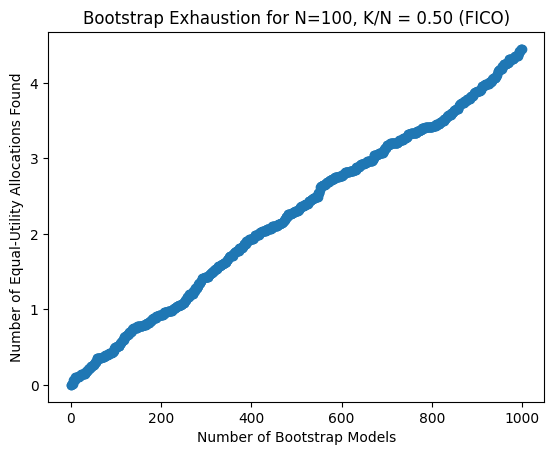

In [22]:
k_n = 0.50
data = np.array(allocations_growth[k_n])
data = np.mean(data, axis=0)

x = np.arange(len(data))
plt.plot(x, data, marker='o')

plt.title('FICO Bootstrap Exhaustion for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.xlabel('Number of Bootstrap Models')
plt.ylabel('Number of Equal-Utility Allocations Found')

plt.show()

## Individual Fairness: Selection Frequency

In [36]:
for rate in SELECTION_RATES:
    qualified_count[rate] = [item for sublist in qualified_count[rate] for item in sublist]
    unqualified_count[rate] = [item for sublist in unqualified_count[rate] for item in sublist]

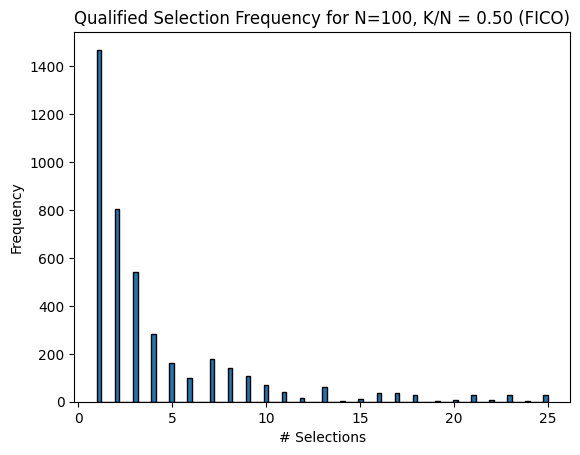

In [49]:
k_n = 0.50
plt.hist(qualified_count[k_n], bins=100, edgecolor='black')

plt.xlabel('# Selections')
plt.ylabel('Frequency')
plt.title('FICO Qualified Selection Frequency for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.show()

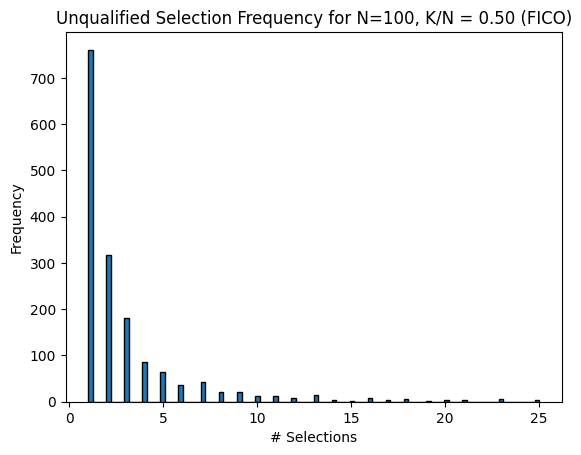

In [50]:
k_n = 0.50
plt.hist(unqualified_count[k_n], bins=100, edgecolor='black')

plt.xlabel('# Selections')
plt.ylabel('Frequency')
plt.title('FICO Qualified Selection Frequency for N='+str(TEST_SIZE)+' , K/N ='+str(k_n))
plt.show()